In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMClassifier
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#%% EXPLORATORY DATA ANALYSIS
df = pd.read_csv('churn_data.csv', sep=',', header=0)
df
print(df.shape)

(50079, 100)


In [3]:
"""Analyzing missing values in values"""
df.info
print(df.isnull().sum()) # Handling missing value and there is no missing valu on churn column.
print(df.isnull().sum().any())

Customer_ID      0
rev_Mean       147
mou_Mean       147
totmrc_Mean    147
da_Mean        147
              ... 
kid11_15       904
kid16_17       904
creditcd       904
eqpdays          1
churn            0
Length: 100, dtype: int64
True


In [4]:
"Dropping features with more than 10 percent missing values"
olddf = df.columns
perc = 10.0
nan_min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna(axis=1, thresh=nan_min_count)
newdf = df.columns
df.shape
print("Eliminating features:\n",list(set(olddf) - set(newdf)))

Eliminating features:
 ['dwllsize', 'income', 'HHstatin', 'lor', 'numbcars', 'adults', 'ownrent', 'infobase', 'hnd_webcap', 'dwlltype']


In [5]:
"""Analyzing statistics values"""
print(df.describe())
print(df.head(5))
print(df.tail(5))
print(df.sample(5))


        Customer_ID      rev_Mean      mou_Mean   totmrc_Mean       da_Mean  \
count  5.007900e+04  49932.000000  49932.000000  49932.000000  49932.000000   
mean   1.049990e+06     58.605808    511.867777     46.170711      0.886424   
std    2.882829e+04     44.432651    523.521413     23.700695      2.187620   
min    1.000001e+06     -5.862500      0.000000     -9.030000      0.000000   
25%    1.025054e+06     33.240000    148.750000     30.000000      0.000000   
50%    1.049970e+06     48.001250    354.250000     44.990000      0.247500   
75%    1.074975e+06     70.745000    698.250000     59.990000      0.742500   
max    1.099998e+06    983.125000   6704.250000    409.990000     72.765000   

        ovrmou_Mean   ovrrev_Mean   vceovr_Mean   datovr_Mean     roam_Mean  \
count  49932.000000  49932.000000  49932.000000  49932.000000  49932.000000   
mean      41.206099     13.582805     13.318369      0.261355      1.202173   
std       98.741371     30.712862     30.319873    

In [6]:
"""Checking columns names"""
col_names = df.columns
print(col_names)

Index(['Customer_ID', 'rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean',
       'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean',
       'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean',
       'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean',
       'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean',
       'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean',
       'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean',
       'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs',
       'actvsubs', 'new_cell', 'crclscod', 'asl_flag', 'totcalls', 'totmou',
       'totrev', 'a

In [7]:
"""Dropping the same values in the rows"""
print(df.shape)
df = df.drop_duplicates() # Dropping and Checking the same row including the data.
print(df.drop_duplicates().any()) # There is no same row in the data.

90
Customer_ID    True
rev_Mean       True
mou_Mean       True
totmrc_Mean    True
da_Mean        True
               ... 
kid11_15       True
kid16_17       True
creditcd       True
eqpdays        True
churn          True
Length: 90, dtype: bool


In [8]:
"Checking how many churn on the data"
print(df.churn.value_counts()) # It is balanced data.

0    25139
1    24940
Name: churn, dtype: int64


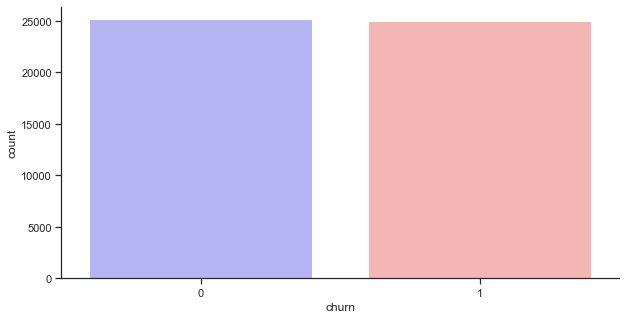

In [9]:
"""Creating the Histogram plot"""
sns.set(style="ticks")
g = sns.countplot(x="churn", data=df, palette="bwr")
sns.despine()
g.figure.set_size_inches(10,5)
plt.show()

In [10]:
"""Checking whether the data includes categorical values"""
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :', categorical)
df[categorical].head()

There are 15 categorical variables

The categorical variables are : ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new', 'marital', 'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']


,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,marital,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,A,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,S,N,U,U,U,U,U,Y
1,Y,B,N,T,CHICAGO AREA,N,N,M,U,Y,U,U,U,U,Y
2,Y,C,N,U,GREAT LAKES AREA,N,N,S,U,U,U,U,U,U,Y
3,N,A,N,C,DALLAS AREA,Y,N,M,N,U,U,U,U,U,Y
4,Y,B,N,S,CHICAGO AREA,Y,N,M,F,U,U,U,U,U,N


In [11]:
"""finding numerical variables"""
numerical = [var for var in df.columns if df[var].dtype!='O']
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)
df[numerical].head()

There are 75 numerical variables

The numerical variables are : ['Customer_ID', 'rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 

,Customer_ID,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,...,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,forgntvl,eqpdays,churn
0,1000001,23.9975,219.25,22.50,0.2475,0.0,0.00,0.00,0.0,0.0,...,136.0,38.0,149.98999,2.0,2.0,0.0,0.0,0.0,361.0,1
1,1000004,38.0000,7.50,38.00,0.0000,0.0,0.00,0.00,0.0,0.0,...,25.0,40.0,29.98999,1.0,1.0,0.0,0.0,0.0,1812.0,0
2,1000006,82.2750,1312.25,75.00,1.2375,0.0,0.00,0.00,0.0,0.0,...,853.0,78.0,129.98999,9.0,4.0,0.0,0.0,0.0,458.0,0
3,1000007,17.1450,0.00,16.99,0.0000,0.0,0.00,0.00,0.0,0.0,...,0.0,17.0,29.98999,4.0,3.0,0.0,0.0,0.0,852.0,1
4,1000009,97.3375,1039.00,50.00,4.9500,419.5,41.95,41.95,0.0,0.0,...,434.0,90.0,29.98999,3.0,3.0,0.0,0.0,0.0,700.0,0


In [12]:
print(round(df[numerical].describe()),2)

       Customer_ID  rev_Mean  mou_Mean  totmrc_Mean  da_Mean  ovrmou_Mean  \
count      50079.0   49932.0   49932.0      49932.0  49932.0      49932.0   
mean     1049990.0      59.0     512.0         46.0      1.0         41.0   
std        28828.0      44.0     524.0         24.0      2.0         99.0   
min      1000001.0      -6.0       0.0         -9.0      0.0          0.0   
25%      1025054.0      33.0     149.0         30.0      0.0          0.0   
50%      1049970.0      48.0     354.0         45.0      0.0          2.0   
75%      1074975.0      71.0     698.0         60.0      1.0         42.0   
max      1099998.0     983.0    6704.0        410.0     73.0       4321.0   

       ovrrev_Mean  vceovr_Mean  datovr_Mean  roam_Mean  ...  avg6qty  \
count      49932.0      49932.0      49932.0    49932.0  ...  48653.0   
mean          14.0         13.0          0.0        1.0  ...    178.0   
std           31.0         30.0          3.0        7.0  ...    183.0   
min           

In [13]:
"Filling mode of the data instead of NaN values"
for i in df.columns:
    df[i] = df[i].fillna(df[i].mode()[0])
df.isnull().sum().any()
# There is no missing values in the data.

False

In [14]:
"Performing label encoding non numeric values"
for i in categorical:
    encoder = LabelEncoder()
    df[i] = encoder.fit_transform(df[i])

In [15]:
"""Checking whether the data includes categorical values again after label encoding"""
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))

There are 0 categorical variables



In [16]:
"Analyzing with target value(churn)"
print(df.shape)
def find_correlated_features(df, threshold, target_variable):
    s = df.corr().loc[target_variable].drop(target_variable)
    return s[s.abs() >= threshold]
find_correlated_features(df, .05, 'churn')
print(df.shape)
#The best feature correlated to target value is eqpdays (0.11)

(50079, 90)
(50079, 90)


In [16]:
"spliting features and target values"
Target = df['churn']
df = df.drop('churn', axis = 1)

In [17]:
"Creating correlation matrix features without target value"
olddf = df.columns
print("Before eliminating shape: ",df.shape)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Keeping at least any feature in data.
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Dropping features columns with correlation greater than 0.95
df = df.drop(df[to_drop], axis=1)
newdf = df.columns
print("After eliminating shape: ",df.shape)
print("Eliminating features:\n",list(set(olddf) - set(newdf)))

Before eliminating shape:  (50079, 89)
After eliminating shape:  (50079, 75)
Eliminating features:
 ['attempt_Mean', 'avg3mou', 'adjrev', 'cc_mou_Mean', 'adjqty', 'mou_opkd_Mean', 'vceovr_Mean', 'avg3rev', 'complete_Mean', 'comp_dat_Mean', 'inonemin_Mean', 'ovrrev_Mean', 'adjmou', 'comp_vce_Mean']


In [18]:
"Dropping columns that unnecessary column on the data"
print(df.shape)
df = df.drop('Customer_ID', axis = 1)
print(df.shape)

(50079, 75)
(50079, 74)


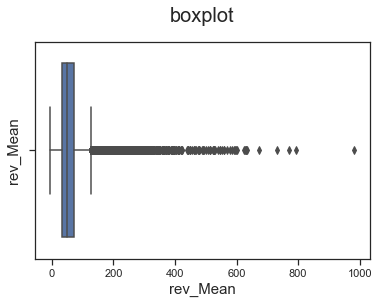

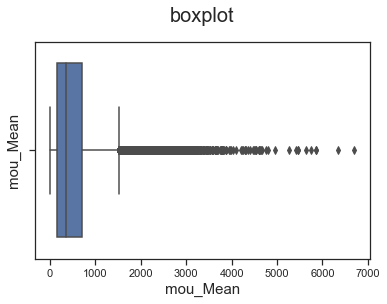

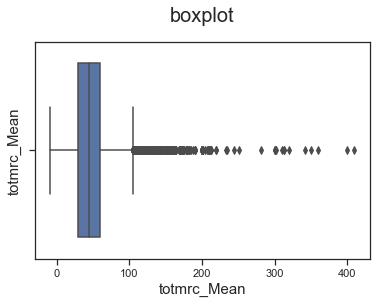

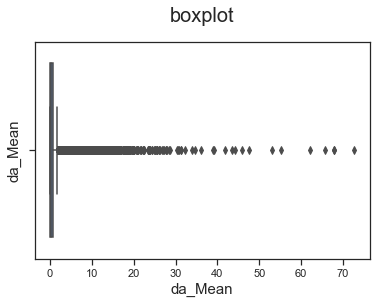

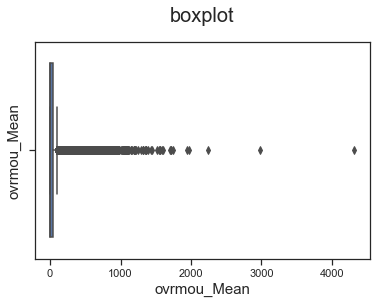

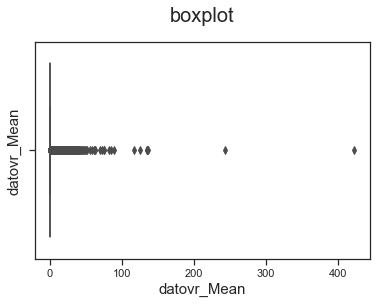

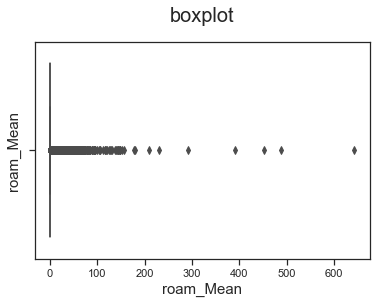

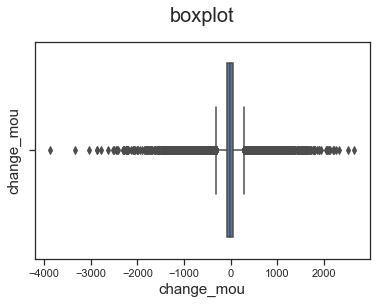

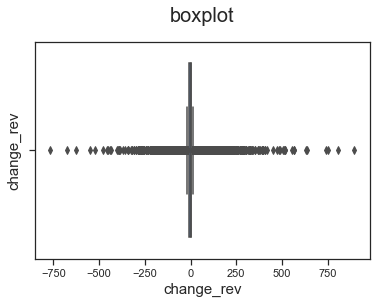

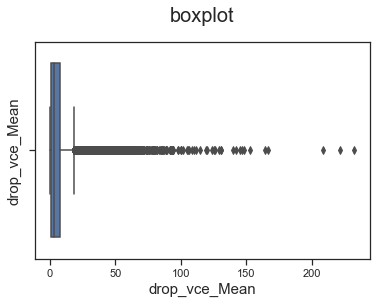

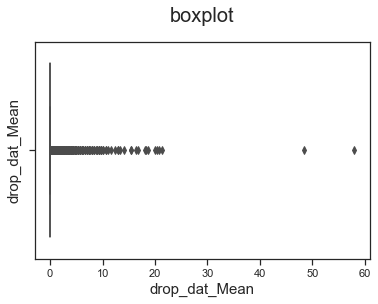

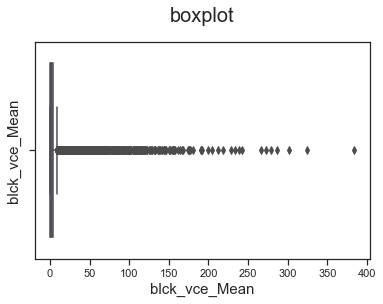

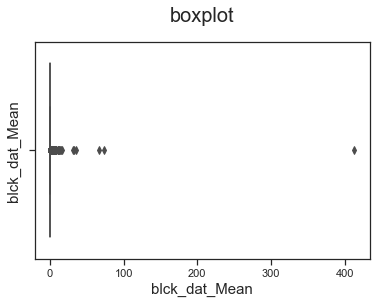

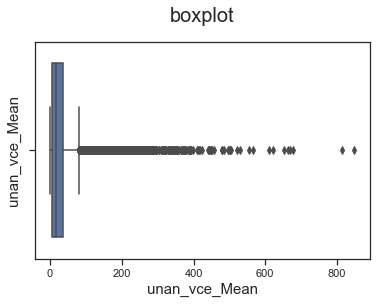

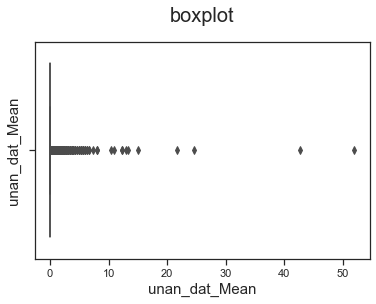

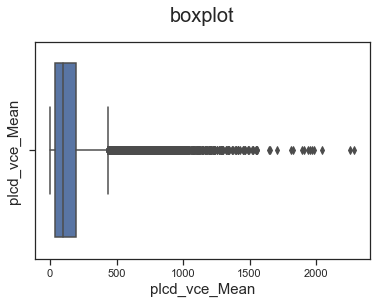

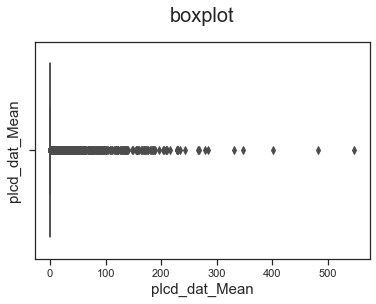

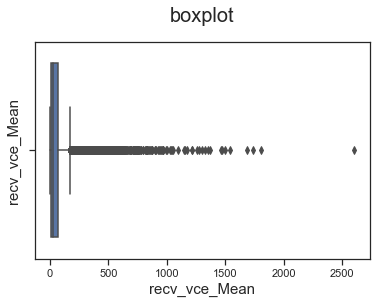

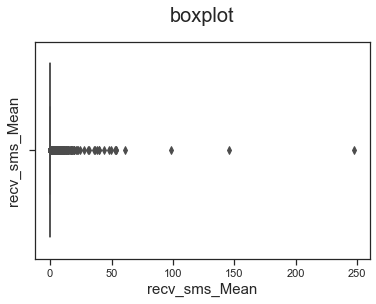

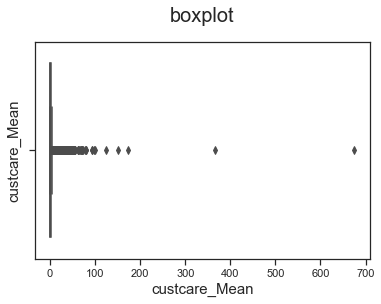

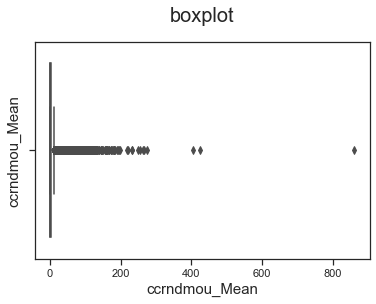

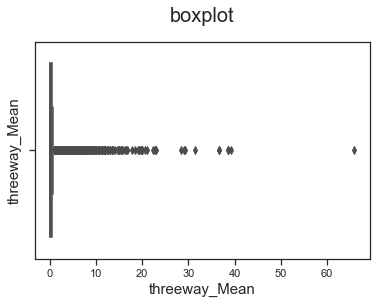

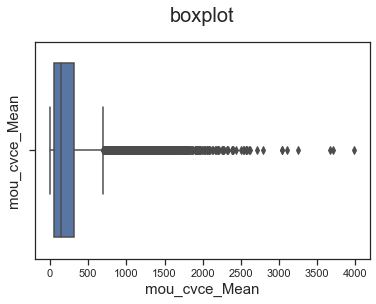

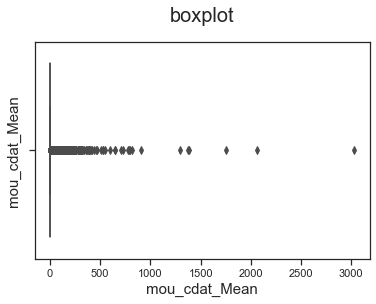

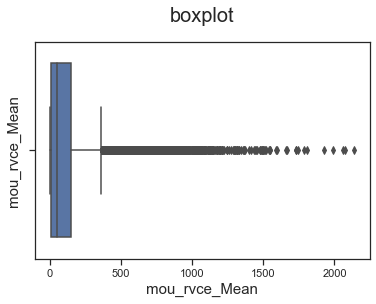

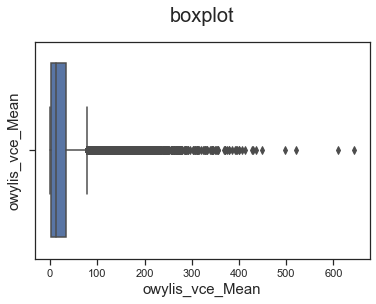

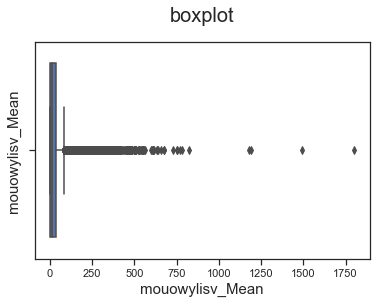

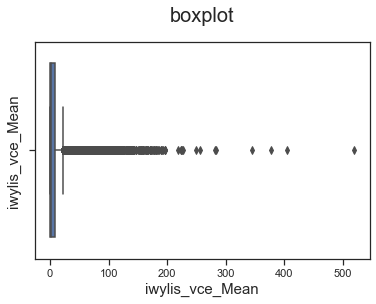

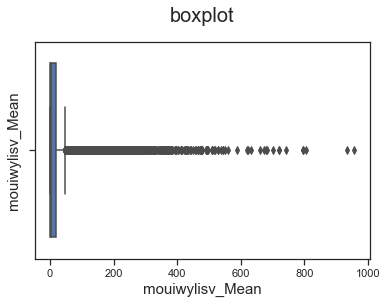

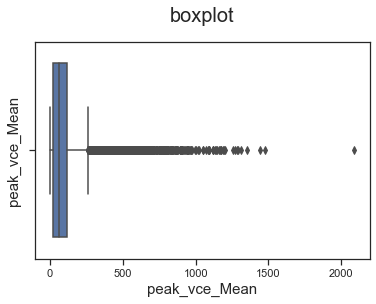

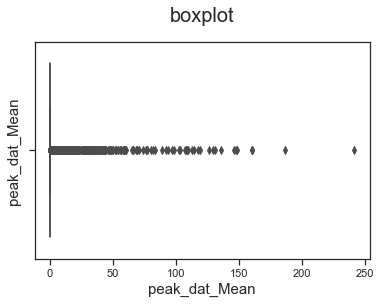

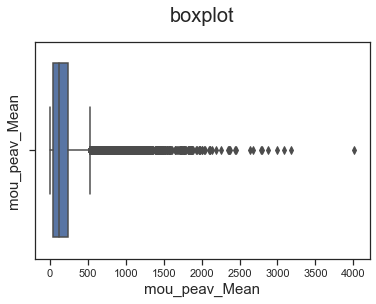

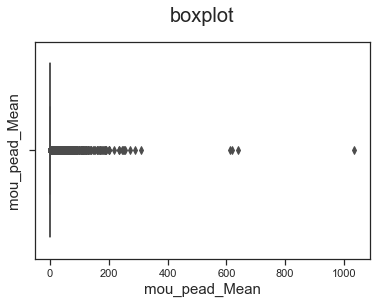

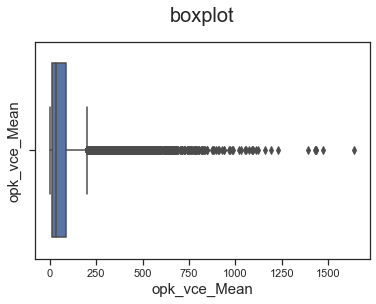

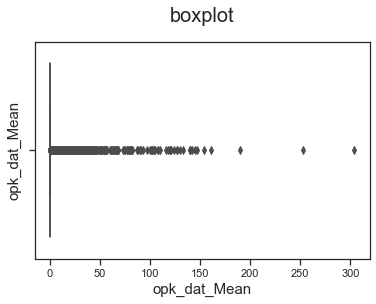

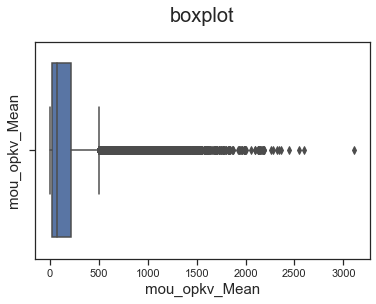

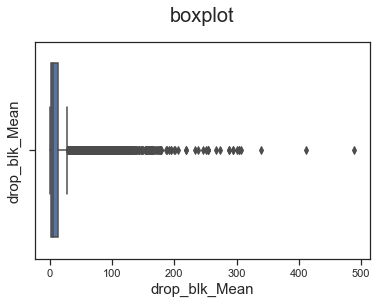

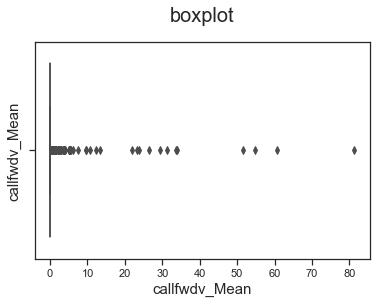

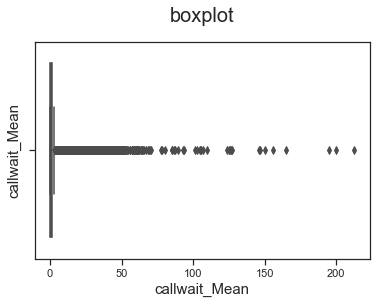

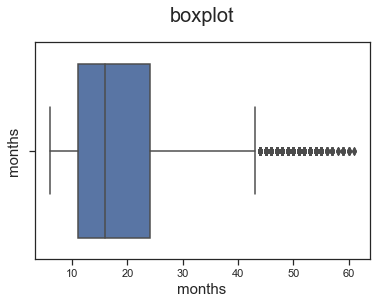

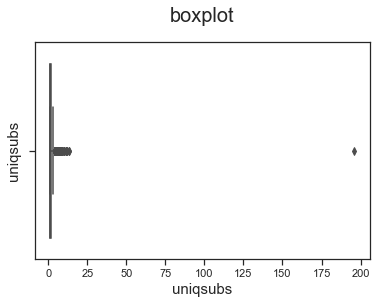

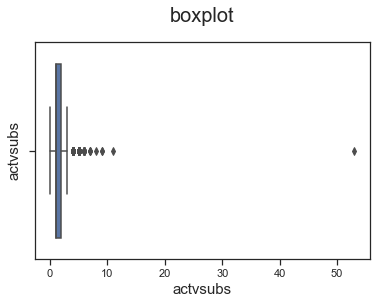

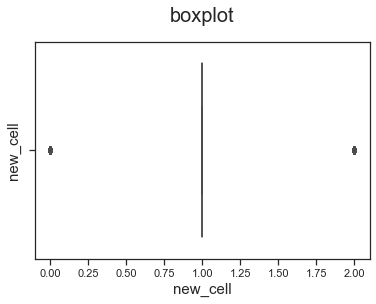

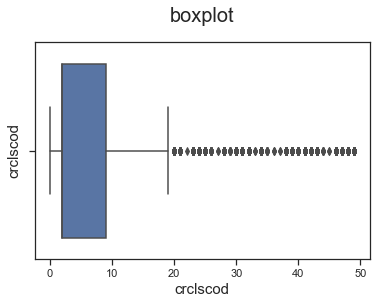

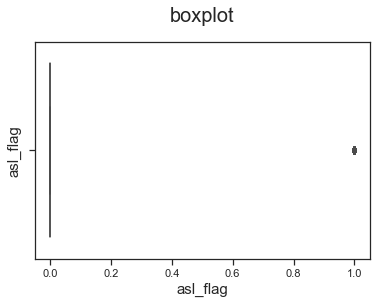

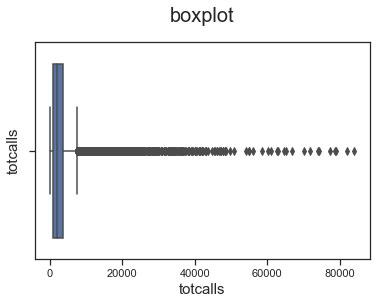

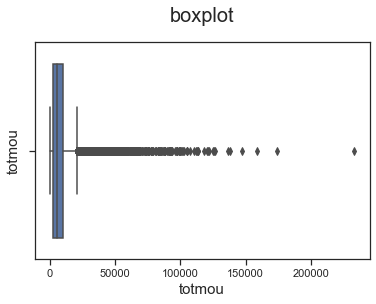

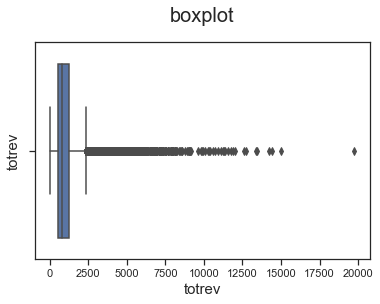

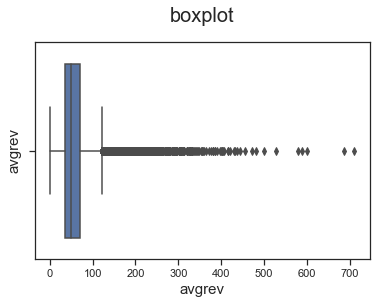

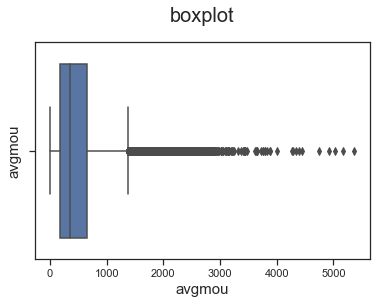

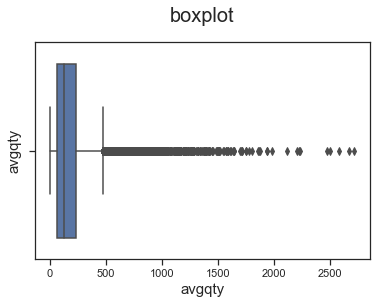

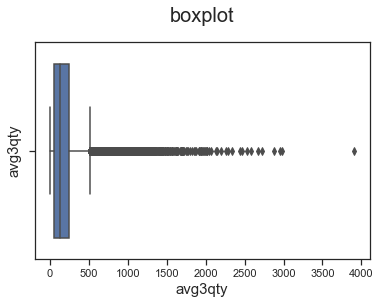

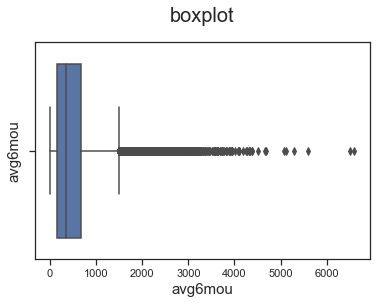

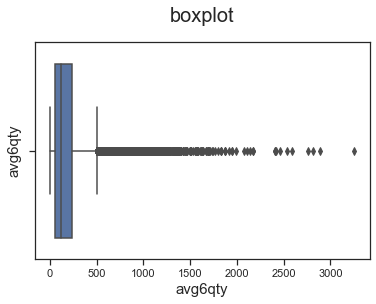

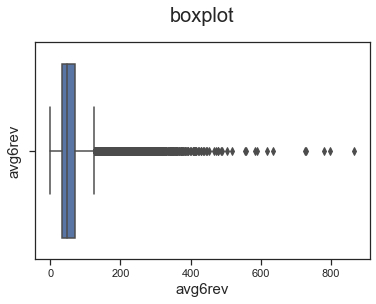

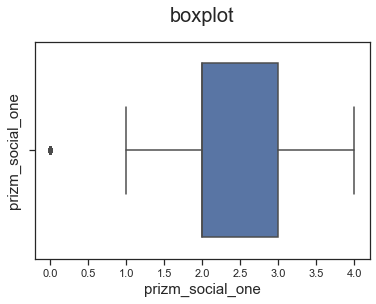

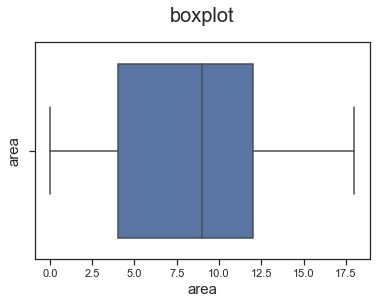

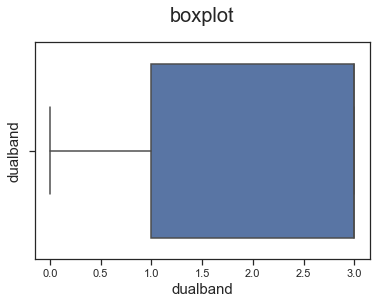

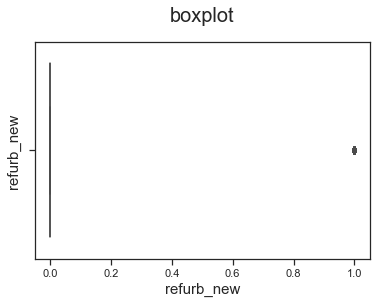

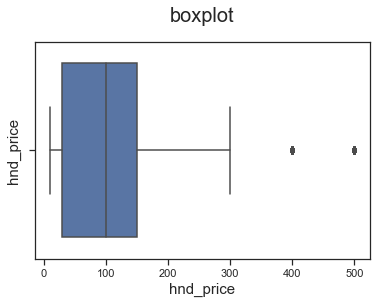

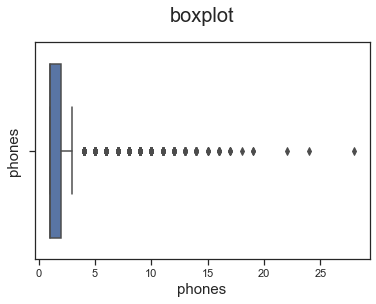

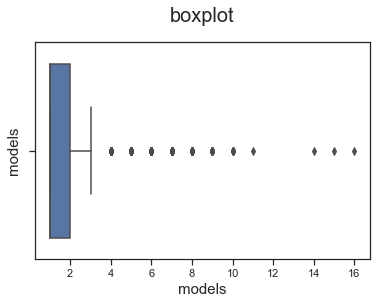

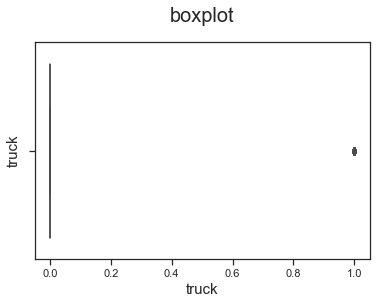

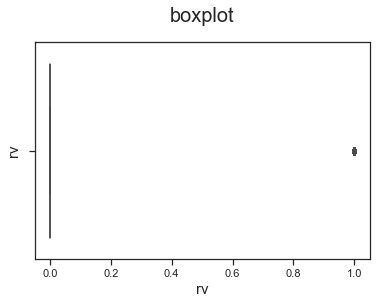

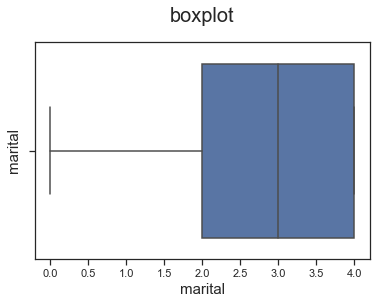

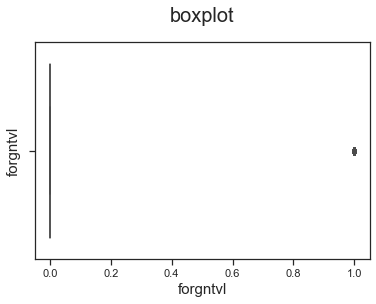

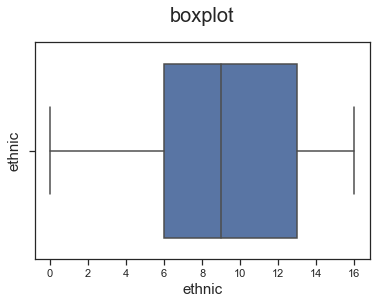

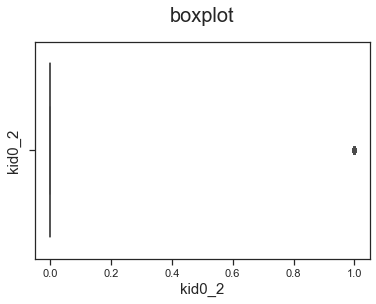

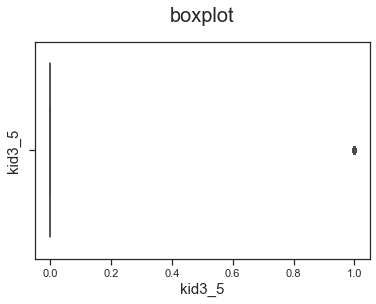

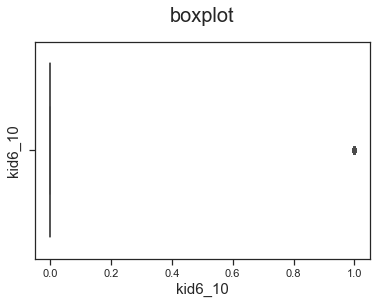

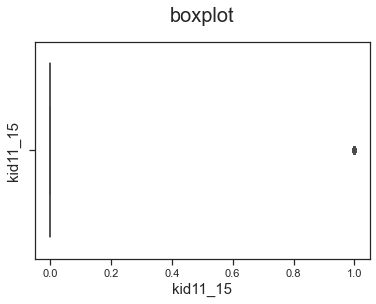

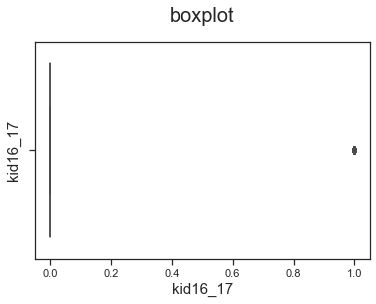

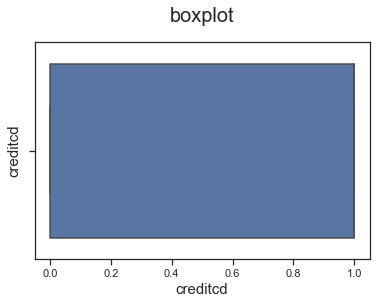

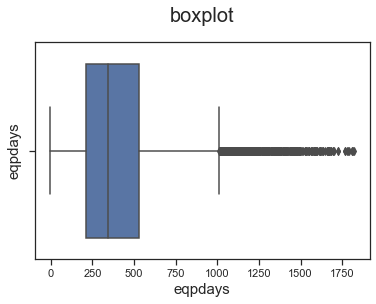

In [19]:
"creating the BoxPlot"
for feature in df.columns:
    ax = sns.boxplot(x = df[feature])
    ax.set_xlabel(feature, fontsize = 15)
    ax.set_ylabel(feature, fontsize = 15)
    ax.set_title("boxplot", fontsize = 20, pad = 20)
    plt.show()
    #Boxplots confirm that there are lot of outliers in these variables.

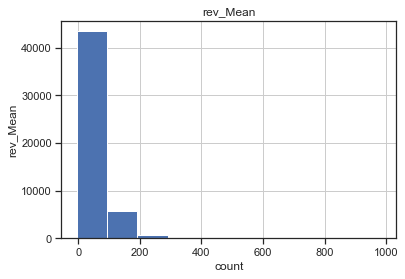

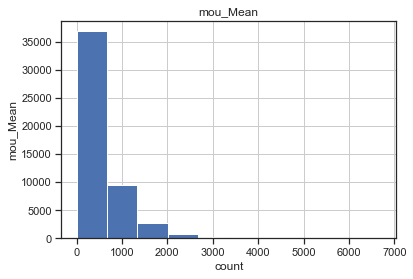

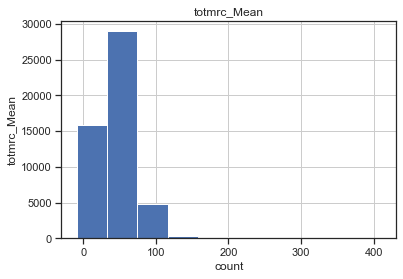

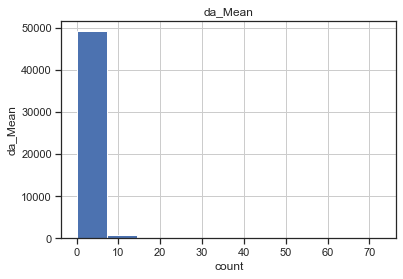

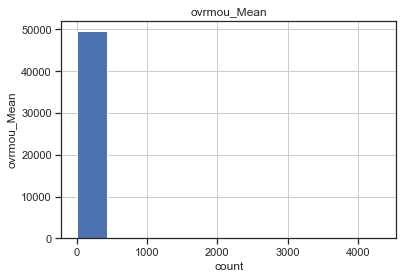

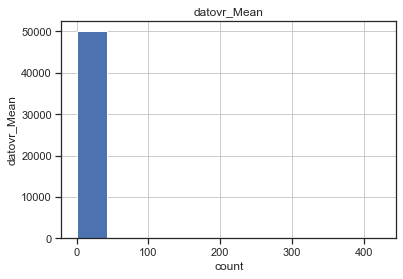

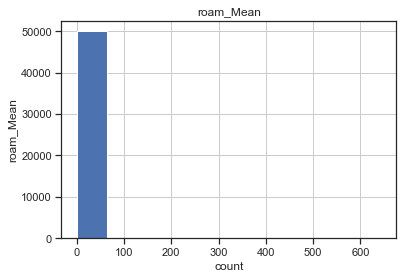

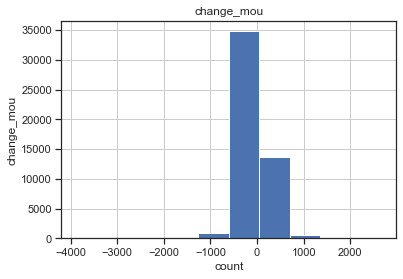

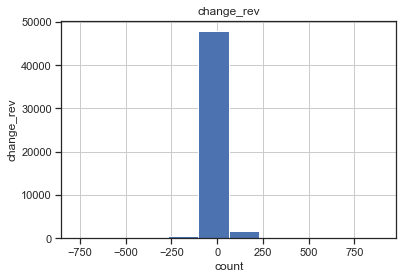

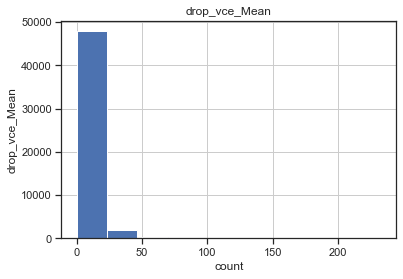

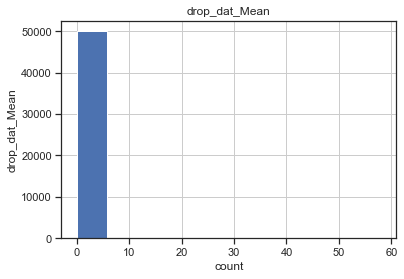

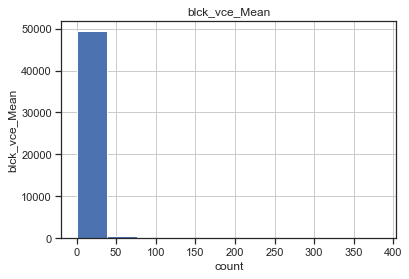

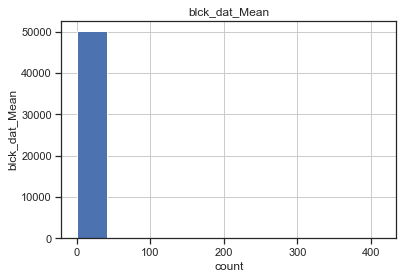

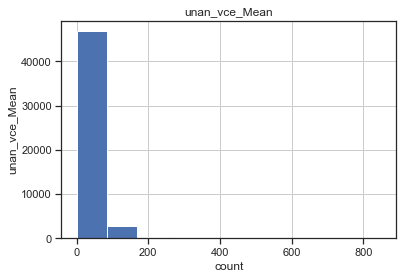

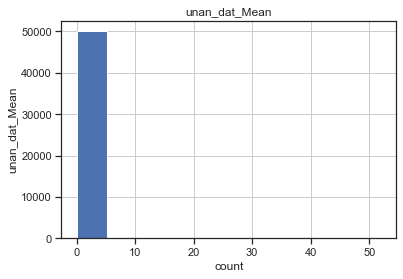

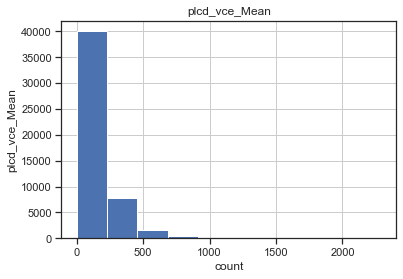

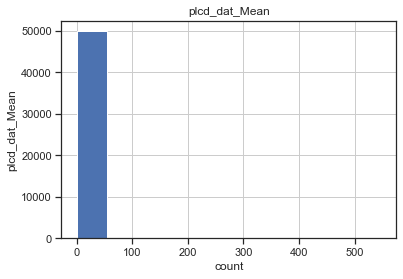

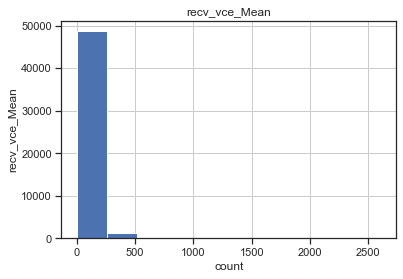

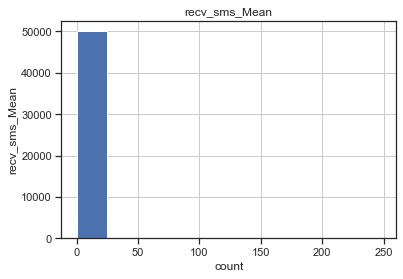

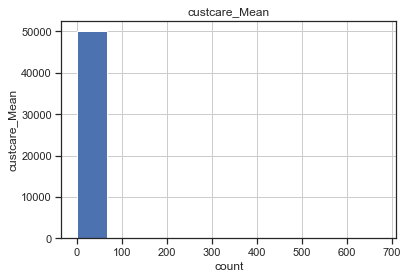

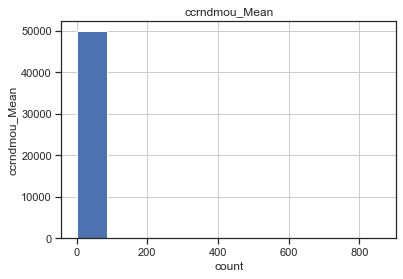

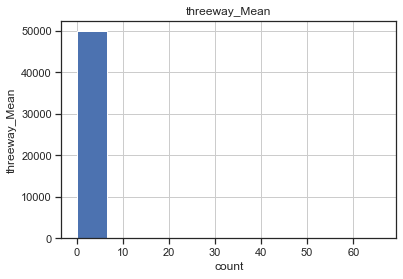

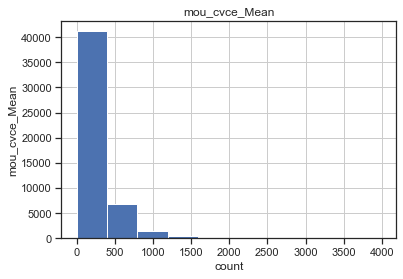

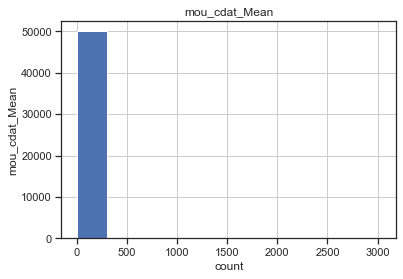

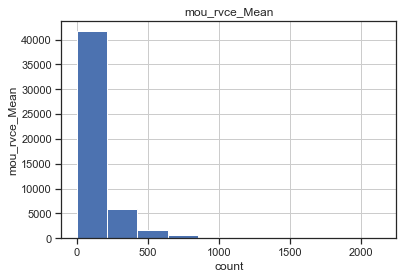

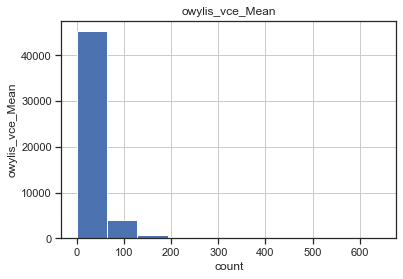

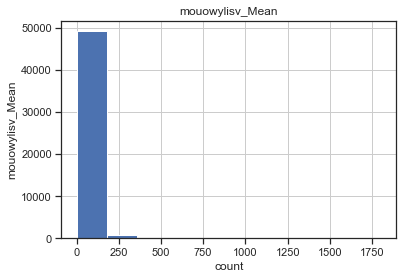

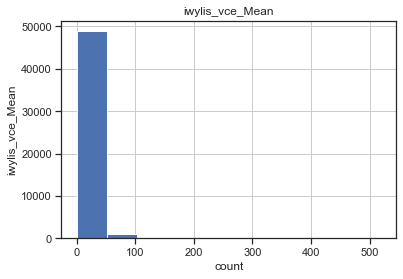

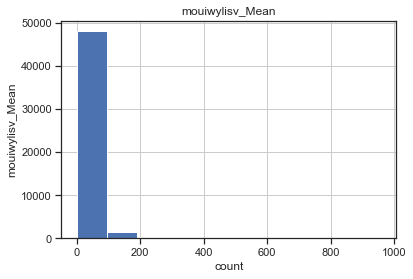

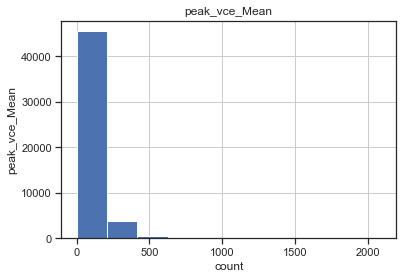

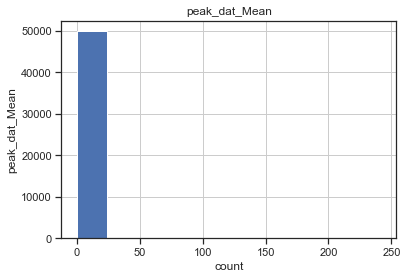

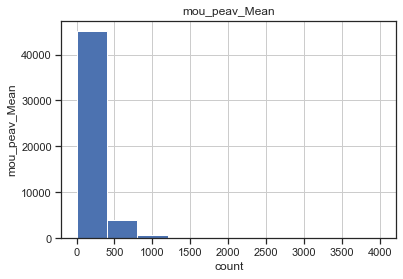

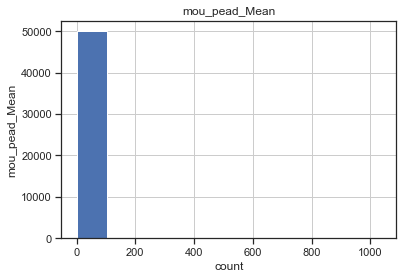

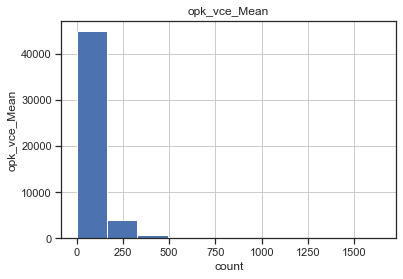

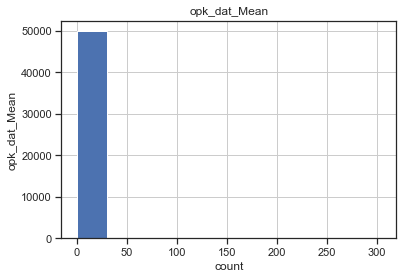

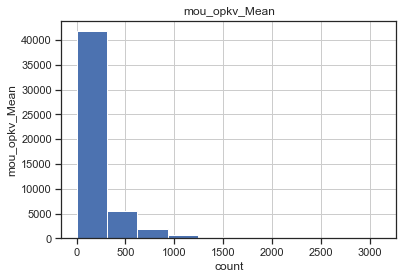

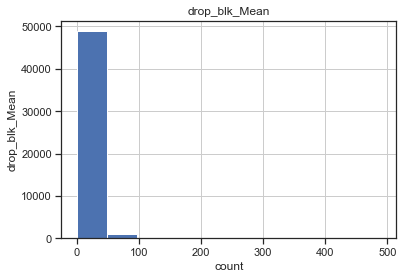

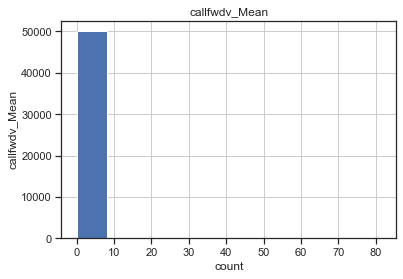

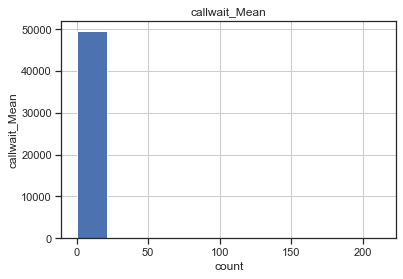

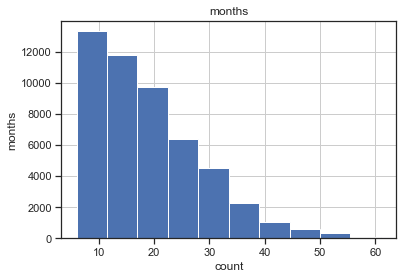

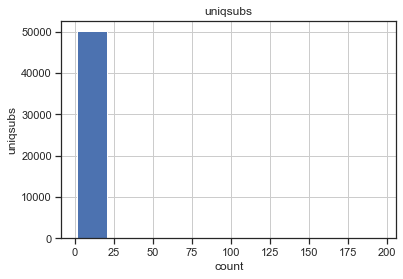

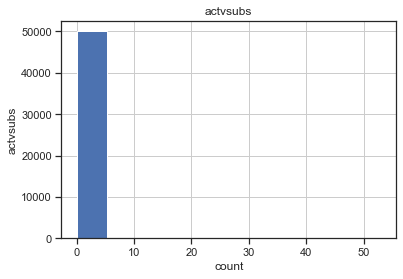

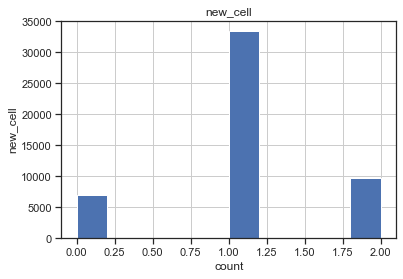

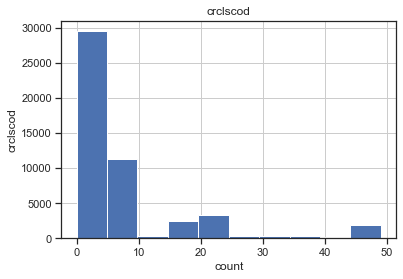

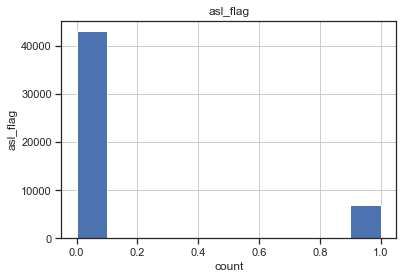

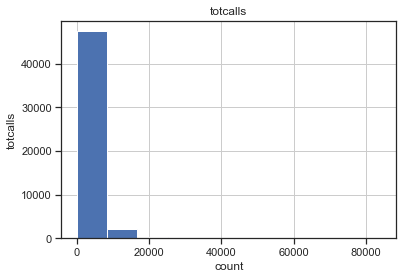

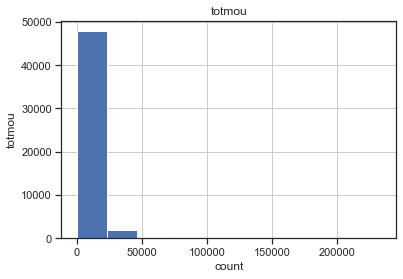

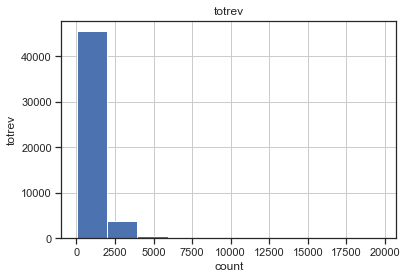

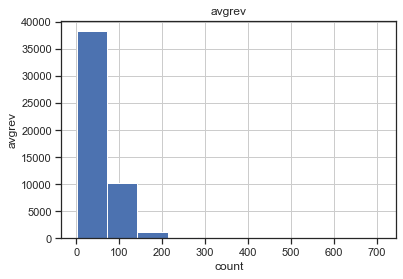

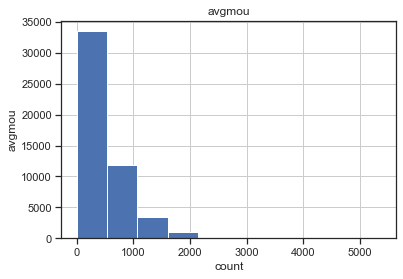

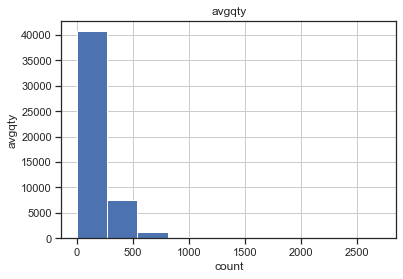

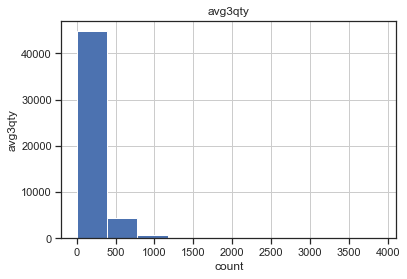

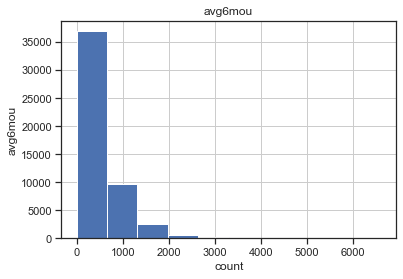

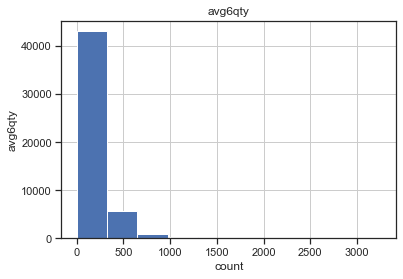

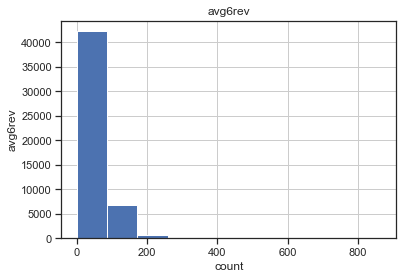

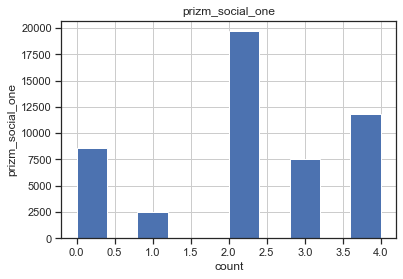

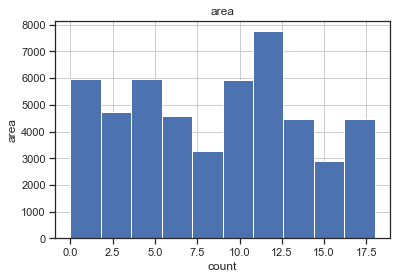

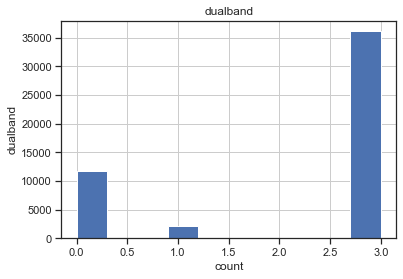

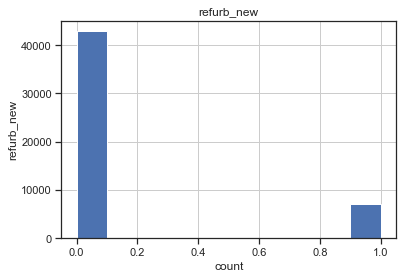

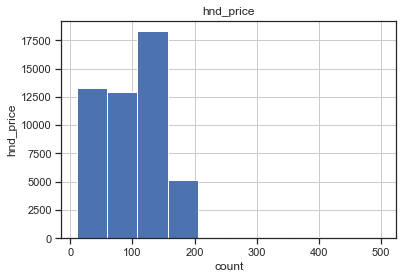

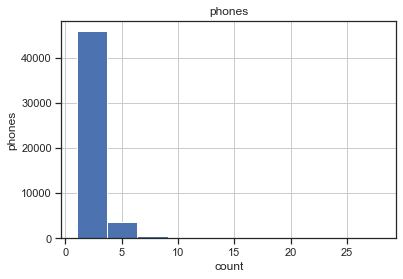

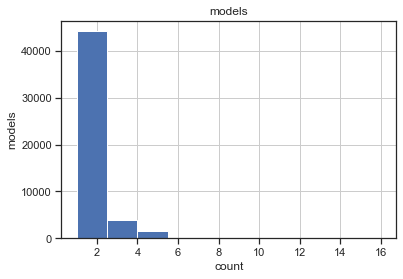

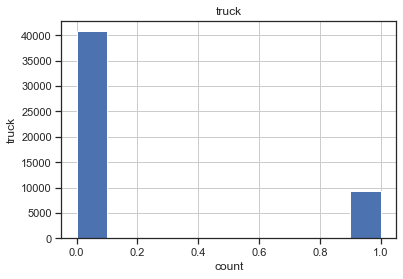

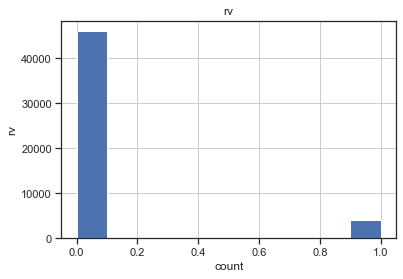

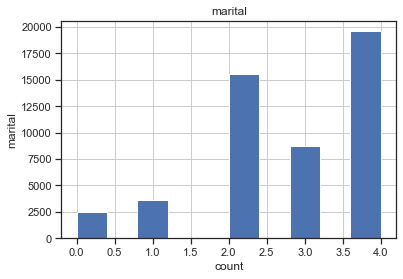

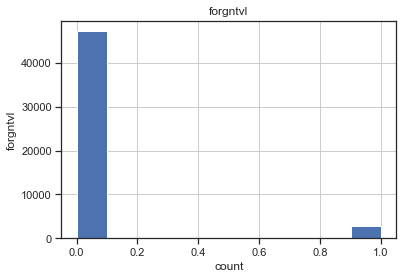

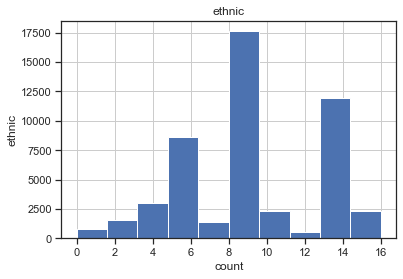

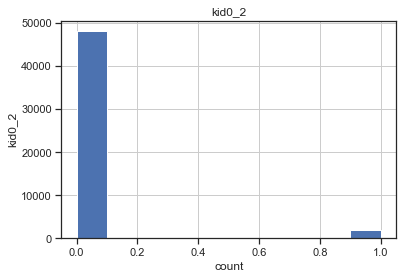

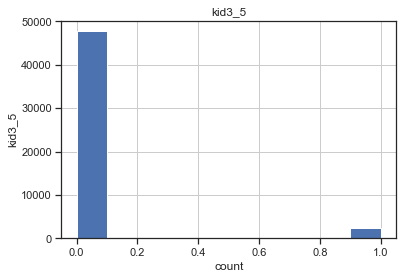

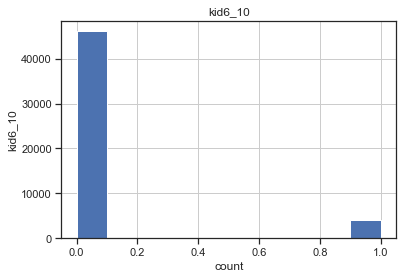

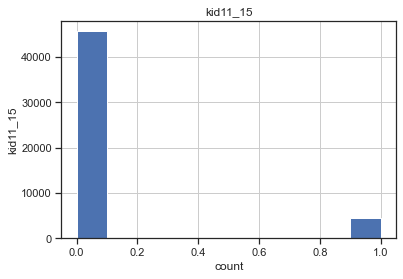

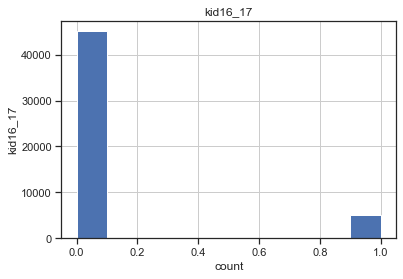

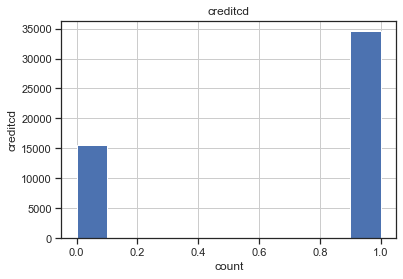

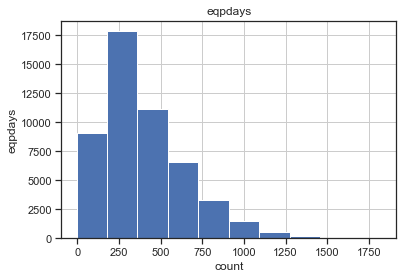

In [20]:
"creating the histograms"
for feature in df.columns:
    df.hist(column=feature)
    pyplot.ylabel(feature)
    pyplot.xlabel("count")
    pyplot.title(feature)
    pyplot.show()

In [24]:
"previewing view the summary of dataset"
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50079 entries, 0 to 50078
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev_Mean          50079 non-null  float64
 1   mou_Mean          50079 non-null  float64
 2   totmrc_Mean       50079 non-null  float64
 3   da_Mean           50079 non-null  float64
 4   ovrmou_Mean       50079 non-null  float64
 5   datovr_Mean       50079 non-null  float64
 6   roam_Mean         50079 non-null  float64
 7   change_mou        50079 non-null  float64
 8   change_rev        50079 non-null  float64
 9   drop_vce_Mean     50079 non-null  float64
 10  drop_dat_Mean     50079 non-null  float64
 11  blck_vce_Mean     50079 non-null  float64
 12  blck_dat_Mean     50079 non-null  float64
 13  unan_vce_Mean     50079 non-null  float64
 14  unan_dat_Mean     50079 non-null  float64
 15  plcd_vce_Mean     50079 non-null  float64
 16  plcd_dat_Mean     50079 non-null  float6

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,...,marital,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
0,23.9975,219.25,22.50,0.2475,0.0,0.0,0.0,-157.25,-18.9975,0.666667,...,3,0.0,9,0,0,0,0,0,1,361.0
1,38.0000,7.50,38.00,0.0000,0.0,0.0,0.0,-1.50,0.0000,0.000000,...,2,0.0,14,1,0,0,0,0,1,1812.0
2,82.2750,1312.25,75.00,1.2375,0.0,0.0,0.0,156.75,8.1450,52.000000,...,3,0.0,14,0,0,0,0,0,1,458.0
3,17.1450,0.00,16.99,0.0000,0.0,0.0,0.0,0.00,-0.1550,0.000000,...,2,0.0,9,0,0,0,0,0,1,852.0
4,97.3375,1039.00,50.00,4.9500,419.5,0.0,0.0,198.00,23.2625,12.666667,...,2,0.0,3,0,0,0,0,0,0,700.0


In [21]:
"creating KFold, Test and Training set"
X_train, X_test, y_train, y_test = train_test_split(df, Target, test_size = 0.30, shuffle=True) 
# It is not time-series data, therefore I used True on shuffle.
kf = KFold(n_splits=3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35055, 74)
(15024, 74)
(35055,)
(15024,)


In [22]:
"implementing StandardScaling to the features"
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

In [23]:
"implementing Principal Component Analysis(PCA)"
pca = PCA(0.95)
pca.fit(train_scaled)

train_pca = pca.transform(train_scaled)
test_pca = pca.transform(test_scaled)

print("variance ratio:", pca.explained_variance_ratio_) 
print("sum:",sum(pca.explained_variance_ratio_))

# I aim to minimize the loss of the data therefore I chose 0.95. 
# In other words, after implementing PCA, total data loss is %0.5.

print(train_pca.shape)
print(test_pca.shape)


variance ratio: [0.16534019 0.1004116  0.0836257  0.07092892 0.06769791 0.05832459
 0.05616458 0.04441174 0.04317163 0.0419342  0.03325909 0.0301874
 0.02873593 0.02748369 0.02644447 0.02200592 0.01878757 0.01852276
 0.01685538]
sum: 0.9542932685970502
(35055, 19)
(15024, 19)


In [24]:
#%%#################################
############ Algorithms ############
####################################

algorithms = "Decision Tree", "Logistic Regression", "LightGBM", "Gradient Boosting"


def optimize(hyperparameter_tuning, trials, random_state, space, n_iter):
    best=fmin(fn=hyperparameter_tuning, # function to optimize
              space=space, # parameters
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=n_iter, # maximum number of iterations
              trials=trials) # logging
    return best


def search_algorithms(X_train,y_train,X_test):
    random_state=42
    n_iter=100

    """Hyperopt Decision Tree Classifier"""
    space = {
        'max_depth': hp.quniform('max_depth', 1, 100, 5),
        'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 100, 1)
        }
    def hyperparameter_tuning(params, random_state=random_state, cv=kf, X=X_train, y=y_train):
        params = {'max_depth': int(params['max_depth']),
                  'min_samples_split': int(params['min_samples_split']),       
                  'min_samples_leaf': int(params['min_samples_leaf'])
                  }
        dt_cls = DecisionTreeClassifier(random_state=random_state, **params)
        score = -cross_val_score(dt_cls, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
        # I aim to maximize accuracy, therefore I return it as a negative value.
        return score
    trials = Trials()
    bestdtc = optimize(hyperparameter_tuning, trials, random_state, space, n_iter)
    dt_cls = DecisionTreeClassifier(random_state=random_state,
                                    max_depth=int(bestdtc['max_depth']),
                                    min_samples_split=int(bestdtc['min_samples_split']),
                                    min_samples_leaf=int(bestdtc['min_samples_leaf']))
    dtprediction = dt_cls.fit(X_train,y_train).predict(X_test)

    """Hyperopt Logistic Regression"""
    space = {'warm_start' : hp.choice('warm_start', [True, False]),
             'fit_intercept' : hp.choice('fit_intercept', [True, False]),
             'tol' : hp.uniform('tol', 0.00001, 0.0001),
             'C' : hp.uniform('C', 0.05, 3)}
    def hyperparameter_tuning(params, random_state=random_state, n_folds = kf, X=X_train, y=y_train):
        """Objective function for Logistic Regression Hyperparameter Tuning"""
        clf = LogisticRegression(**params,random_state=random_state)
        score = -cross_val_score(clf, X, y, cv=n_folds, scoring='accuracy', n_jobs=-1).mean()
        return score
    trials = Trials()
    bestlr = optimize(hyperparameter_tuning, trials, random_state, space, n_iter)
    lr_cls = LogisticRegression(random_state=random_state,
                                warm_start=bestlr['warm_start'],
                                fit_intercept=bestlr['fit_intercept'],
                                tol=float(bestlr['tol']),
                                C=float(bestlr['C']))
    lrprediction = lr_cls.fit(X_train,y_train).predict(X_test)

    """Hyperopt LGBM"""
    space= {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
            'max_depth': hp.quniform('max_depth', 2, 20, 1),
            'n_estimators': hp.quniform('n_estimators', 5, 100, 1),
            'num_leaves': hp.quniform('num_leaves', 5, 50, 1),
            'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
            }
    def hyperparameter_tuning(params, random_state=random_state, cv=kf, X=X_train, y=y_train):
        params = {'learning_rate': params['learning_rate'],
                  'max_depth': int(params['max_depth']),
                  'n_estimators': int(params['n_estimators']),
                  'num_leaves': int(params['num_leaves']),       
                  'reg_lambda': params['reg_lambda']
                  }
        model = LGBMClassifier(random_state=random_state, **params)
        score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
        return score
    trials = Trials()
    bestlgbm = optimize(hyperparameter_tuning, trials, random_state, space, n_iter)
    lgbm_cls = LGBMClassifier(random_state=random_state, 
                              learning_rate=bestlgbm['learning_rate'],
                              max_depth=int(bestlgbm['max_depth']),
                              n_estimators=int(bestlgbm['n_estimators']),
                              num_leaves=int(bestlgbm['num_leaves']),
                              reg_lambda=bestlgbm['reg_lambda'])
    lgbmprediction = lgbm_cls.fit(X_train,y_train).predict(X_test)

    """Hyperopt Gradient Boosting Classifier"""
    space= {'n_estimators': hp.quniform('n_estimators', 10, 30, 10),
            'min_samples_split': hp.quniform('min_samples_split', 2, 4, 2),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 4, 2),
            }   
    def hyperparameter_tuning(params, random_state=random_state, cv=kf, X=X_train, y=y_train):
        params = {'n_estimators': int(params['n_estimators']),
                  'min_samples_split': int(params['min_samples_split']),
                  'min_samples_leaf': int(params['min_samples_leaf']),       
                  }
        model = GradientBoostingClassifier(random_state=random_state, **params)
        score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
        return score
    trials = Trials()
    bestgbm = optimize(hyperparameter_tuning, trials, random_state, space, n_iter)
    gbc_cls = GradientBoostingClassifier(random_state=random_state, 
                                         n_estimators=int(bestgbm['n_estimators']),
                                         min_samples_split=int(bestgbm['min_samples_split']),
                                         min_samples_leaf=int(bestgbm['min_samples_leaf']))
    gbmprediction = gbc_cls.fit(X_train,y_train).predict(X_test)


    return bestdtc, bestlr, bestlgbm, bestgbm, dtprediction, lrprediction, lgbmprediction, gbmprediction



In [25]:
#%% Predictions without PCA

bestdtc, bestlr, bestlgbm, bestgbm, dtprediction, lrprediction, lgbmprediction, gbmprediction = search_algorithms(train_scaled,y_train,test_scaled)

prediction = [dtprediction, lrprediction, lgbmprediction, gbmprediction]
hyperoptparam = [bestdtc, bestlr, bestlgbm, bestgbm]
i=0
for bestbest in hyperoptparam:
    print('Accuracy of {}: %.4f'.format(algorithms[i]) % metrics.accuracy_score(y_test, prediction[i]))
    print('F1 Score of {}: %.4f'.format(algorithms[i]) % f1_score(y_test, prediction[i], average='weighted'))
    print("Best params of {} are {}".format(algorithms[i], bestbest))
    i=i+1


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


100%|██████████| 100/100 [07:47<00:00,  4.67s/trial, best loss: -0.6088147197261446]
Accuracy of Decision Tree: 0.5799
F1 Score of Decision Tree: 0.5769
Best params of Decision Tree are {'max_depth': 15.0, 'min_samples_leaf': 98.0, 'min_samples_split': 63.0}
Accuracy of Logistic Regression: 0.5736
F1 Score of Logistic Regression: 0.5569
Best params of Logistic Regression are {'C': 2.9918923477788946, 'fit_intercept': 1, 'tol': 3.5260447826123804e-05, 'warm_start': 0}
Accuracy of LightGBM: 0.5851
F1 Score of LightGBM: 0.5590
Best params of LightGBM are {'learning_rate': 0.09039032483830448, 'max_depth': 17.0, 'n_estimators': 65.0, 'num_leaves': 30.0, 'reg_lambda': 0.4685984312433127}
Accuracy of Gradient Boosting: 0.5911
F1 Score of Gradient Boosting: 0.5715
Best params of Gradient Boosting are {'min_samples_leaf': 4.0, 'min_samples_split': 2.0, 'n_estimators': 30.0}


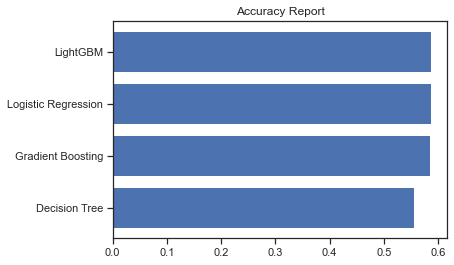

In [31]:
"""Visualizing the accuracy ratios we obtained as a bar chart"""

x = ["Decision Tree", "Logistic Regression", "LightGBM", "Gradient Boosting"]
y = [metrics.accuracy_score(y_test, dtprediction), metrics.accuracy_score(y_test, lrprediction), metrics.accuracy_score(y_test, lgbmprediction), metrics.accuracy_score(y_test, gbmprediction)]
newdf = pd.DataFrame({"Methods":x, "Accuracy":y})
newdf_sorted = newdf.sort_values('Accuracy',ascending=True)
plt.barh('Methods', 'Accuracy',data=newdf_sorted)
plt.title('Accuracy Report')
plt.show()

In [32]:
#%% Predictions with PCA

bestdtcpca, bestlrpca, bestlgbmpca, bestgbmpca, dtpredictionpca, lrpredictionpca, lgbmpredictionpca, gbmpredictionpca = search_algorithms(train_pca,y_train,test_pca)

prediction2 = [dtpredictionpca, lrpredictionpca, lgbmpredictionpca, gbmpredictionpca]
hyperoptparam2 = [bestdtcpca, bestlrpca, bestlgbmpca, bestgbmpca]
i=0
for bestbest2 in hyperoptparam2:
    print('Accuracy of {} with PCA: %.4f'.format(algorithms[i]) % metrics.accuracy_score(y_test, prediction2[i]))
    print('F1 Score of {} with PCA: %.4f'.format(algorithms[i]) % f1_score(y_test, prediction2[i], average='weighted'))
    print("Best params of {} with PCA are {}".format(algorithms[i], bestbest2))
    i=i+1


100%|██████████| 100/100 [05:28<00:00,  3.29s/trial, best loss: -0.5507060333761232]
Accuracy of Decision Tree with PCA: 0.5381
F1 Score of Decision Tree with PCA: 0.5371
Best params of Decision Tree with PCA are {'max_depth': 5.0, 'min_samples_leaf': 65.0, 'min_samples_split': 6.0}
Accuracy of Logistic Regression with PCA: 0.5441
F1 Score of Logistic Regression with PCA: 0.5441
Best params of Logistic Regression with PCA are {'C': 0.2389057502747607, 'fit_intercept': 1, 'tol': 4.200052369701326e-05, 'warm_start': 0}
Accuracy of LightGBM with PCA: 0.5594
F1 Score of LightGBM with PCA: 0.5590
Best params of LightGBM with PCA are {'learning_rate': 0.04015890839940752, 'max_depth': 11.0, 'n_estimators': 74.0, 'num_leaves': 45.0, 'reg_lambda': 0.24765816572309335}
Accuracy of Gradient Boosting with PCA: 0.5542
F1 Score of Gradient Boosting with PCA: 0.5532
Best params of Gradient Boosting with PCA are {'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'n_estimators': 30.0}


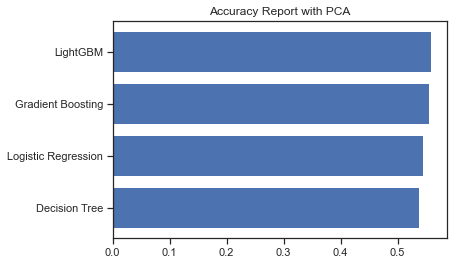

In [33]:
"""Visualizing the accuracy ratios we obtained as a bar chart"""

x = ["Decision Tree", "Logistic Regression", "LightGBM", "Gradient Boosting"]
y = [metrics.accuracy_score(y_test, dtpredictionpca), metrics.accuracy_score(y_test, lrpredictionpca), metrics.accuracy_score(y_test, lgbmpredictionpca), metrics.accuracy_score(y_test, gbmpredictionpca)]
newdf = pd.DataFrame({"Methods with PCA":x, "Accuracy":y})
newdf_sorted = newdf.sort_values('Accuracy',ascending=True)
plt.barh('Methods with PCA', 'Accuracy',data=newdf_sorted)
plt.title('Accuracy Report with PCA')
plt.show()